# Volatility Modelling of Financial Assets

We will study two financial assets' time series, how they follow the stylized facts of financial time series and how we can model their volatility. We look at answering the following questions regarding the time series' behaviour and characteristics, which are related to the stylized facts of financial time series.

* Are the distributions of the empirical returns normal, and thus the asset's distributions log-normal?
* Does the empirical return distributions exhibit traits of leopokurtosis (fat tails)?
* Can we observe 'aggregated normality' between weekly returns and monthly returns?
* Are the returns heteroscedastic? 
* What are good models to describe the returns (and its volatility)?

In studying their stylized facts the following information will be examined.

* Price and return history
* Mean, standard deviation, skewness and excess kurtosis (with confidence)
* Bar-plots of returns
* QQ-plots of return distributions
* Volatility estimation with EqMWA, EWMA and GARCH(1,1) models

In working with volatility models we have an underlying model of the nature of the stock returns (of which volatility we are trying to model). The general model we are working with in this notebook is the following.

$$r_t = \sigma_t \xi_t, \quad \xi_t \overset{\text{iid}}{\sim} N(0,1)$$

This model is quite rudimentary, it has zero drift for instance. This may be resonable to assume for shorter time periods. But for longer periods it might be useful to change this assumption. In addition the shocks are normally distributed. This can be changed quite easily to some other distributions, Student's t, generalized skewed t, generalized normal or Cauchy for example.

### Data Preparation and Visualization

The assets in quetion are the S&P 500 and the AUD/USD currency pair from 2011-12-28 to 2021-12-28. Both weekly and monthly data will be fetch for each respective asset. Note, we are working with log-returns in this notebook, which are asceratined by the expression below. $$R_t = \textrm{ln}(\frac{S_t}{S_{t-1}}) \quad \forall t \in \{1,..,n \}$$

In [1]:
import numpy as np
from pandas_datareader import data as pdr

# Weekly data
spx_weekly = pdr.get_data_yahoo("^GSPC", start="2011-12-28", end="2021-12-28", interval="wk")
spx_weekly = spx_weekly["Adj Close"]
aud_weekly = pdr.get_data_yahoo("AUDUSD=X", start="2011-12-28", end="2021-12-28", interval="wk")
aud_weekly = aud_weekly["Adj Close"]

spx_weekly_returns = np.log(spx_weekly / spx_weekly.shift(1))
aud_weekly_returns = np.log(aud_weekly / aud_weekly.shift(1))

# Monthly data
spx_monthly = pdr.get_data_yahoo("^GSPC", start="2011-12-28", end="2021-12-28", interval="m")
spx_monthly = spx_monthly["Adj Close"]
aud_monthly = pdr.get_data_yahoo("AUDUSD=X", start="2011-12-28", end="2021-12-28", interval="m")
aud_monthly = aud_monthly["Adj Close"]

spx_monthly_returns = np.log(spx_monthly / spx_monthly.shift(1))
aud_monthly_returns = np.log(aud_monthly / aud_monthly.shift(1))

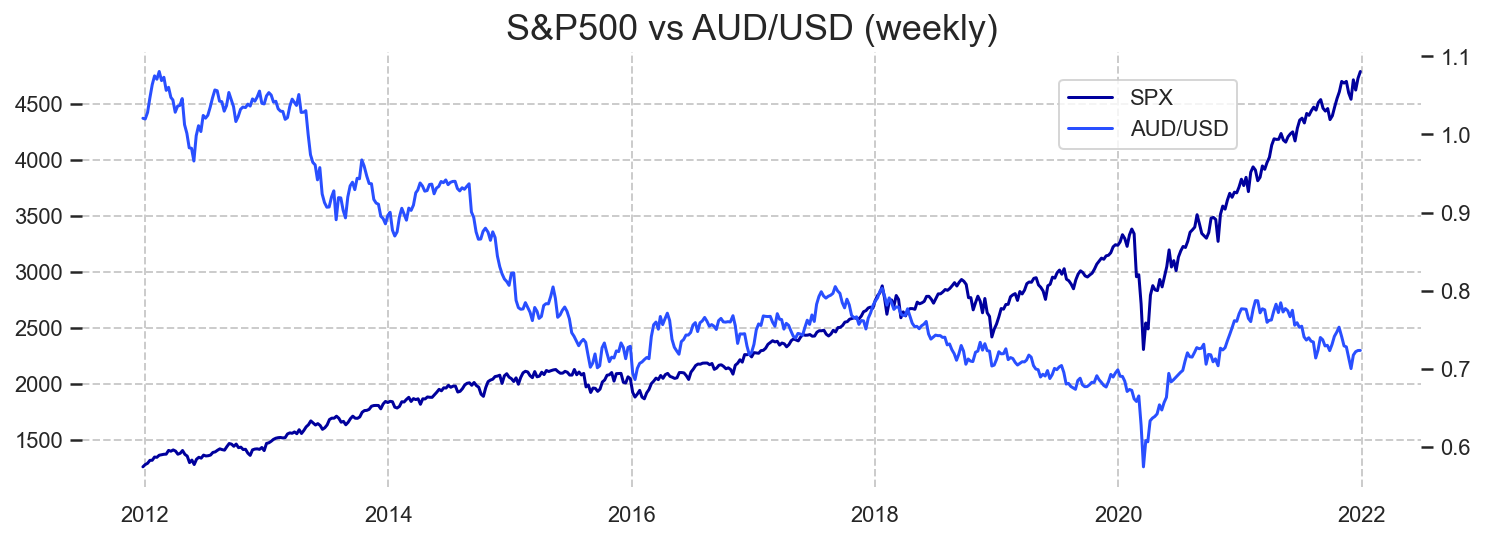

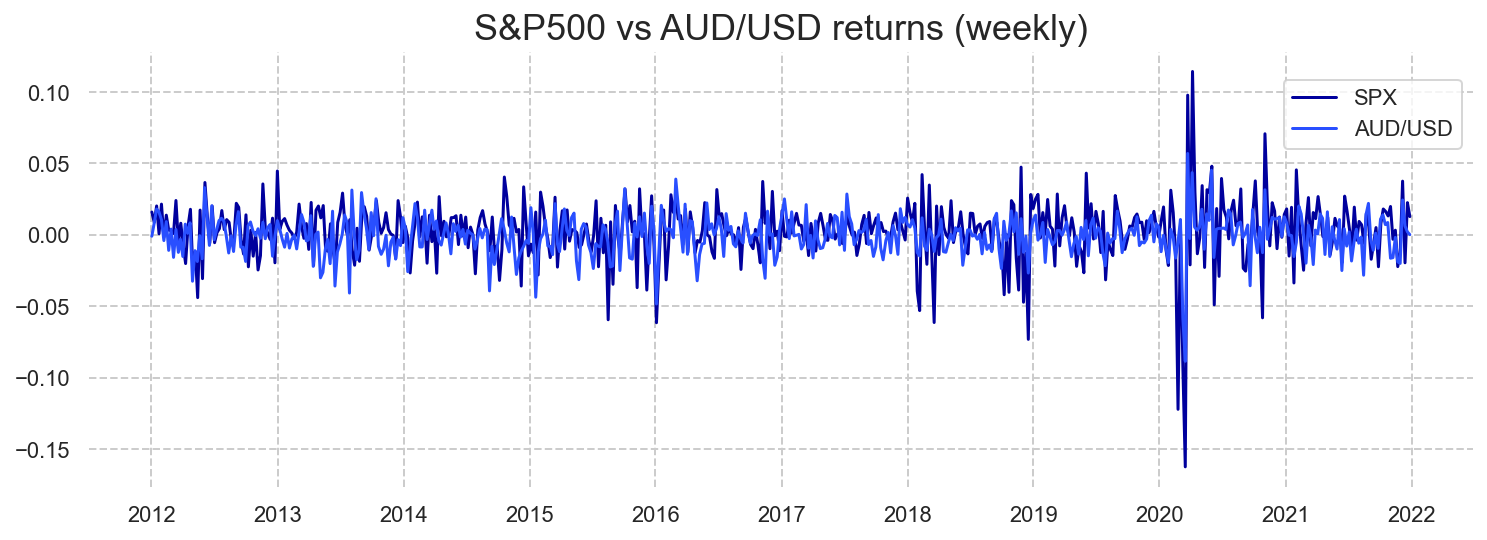

In [2]:
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.grid(False)
ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler

ax1.set_frame_on(False)
ax2.set_frame_on(False)

ax1.plot(spx_weekly, label='SPX')
ax2.plot(aud_weekly, label='AUD/USD')

fig.set_size_inches(12, 4)
fig.legend(loc="upper right", bbox_to_anchor=(0.8,0.85))

plt.title('S&P500 vs AUD/USD (weekly)', fontsize=18)
plt.show()

fig, ax = plt.subplots()
ax.plot(spx_weekly_returns, label='SPX')
ax.plot(aud_weekly_returns, label='AUD/USD')
ax.set_frame_on(False)

fig.set_size_inches(12.4, 4)
fig.legend(loc="upper right", bbox_to_anchor=(0.9,0.85))

plt.title('S&P500 vs AUD/USD returns (weekly)', fontsize=18)
plt.show()

The time series of returns display volatility clustering which is a heteroskedastic behaviour of the time series. This supports that the stochastic processes does not simply have normal distributions.

### Descriptive Statistics

To examine the stylized facts of the time series we look at four statistical measures: mean, standard deviation, skew and (excess) kurtosis. 

The skewness tries to capture whether or not the data is positivley or negativley skewed, which is determined by the sign. 

The kurtosis captures whether or not the data has fat och thin tails. Usually when talking about kurtosis it is implicilty assumed that excess kurtosis is discussed. This is the kurtosis minus that of the normal distribution, which has a kurtosis of $3$. In thisaway we examine if the examined distribution has fatter or thinner tails than the normal distribution. 

The definitions follow below but their unbiased estimators are rather long and tedious. In fact, the unbiased estimator of kurtosis is dependendt on the distribution of the data.

$$ \textrm{Skew}[X] = \mathbb{E}[(\frac{X-\mu}{\sigma})^3]$$

$$ \textrm{Kurt}[X] - 3 = \mathbb{E}[(\frac{X-\mu}{\sigma})^4] - 3$$

In [3]:
import pandas as pd

# Annualized mean returns
means = []
means.append(spx_weekly_returns.mean() * (52/1))
means.append(spx_monthly_returns.mean() * (12/1))
means.append(aud_weekly_returns.mean() * (52/1))
means.append(aud_monthly_returns.mean() * (12/1))

# Annualized sample standard deviations
stds = []
stds.append(spx_weekly_returns.std() * np.sqrt(52/1))
stds.append(spx_monthly_returns.std() * np.sqrt(12/1))
stds.append(aud_weekly_returns.std() * np.sqrt(52/1))
stds.append(aud_monthly_returns.std() * np.sqrt(12/1))

# Skewness 
skews = []
skews.append(spx_weekly_returns.skew())
skews.append(spx_monthly_returns.skew())
skews.append(aud_weekly_returns.skew())
skews.append(aud_monthly_returns.skew())

# Kurtosis
kurts = []
kurts.append(spx_weekly_returns.kurtosis())
kurts.append(spx_monthly_returns.kurtosis())
kurts.append(aud_weekly_returns.kurtosis())
kurts.append(aud_monthly_returns.kurtosis())

index = ['SPX weekly returns', 'SPX monthly returns', 'AUD/USD weekly returns', 'AUD/USD monthly returns']
columns = ['Annualized mean', 'Annualized std', 'Skewness', 'Kurtosis']

df_descriptive_statistics = pd.DataFrame(zip(means, stds, skews, kurts), index=index, columns=columns)
df_descriptive_statistics

,Annualized mean,Annualized std,Skewness,Kurtosis
SPX weekly returns,0.133144,0.153610,-1.280801,11.523748
SPX monthly returns,0.130052,0.130929,-0.697267,2.141690
AUD/USD weekly returns,-0.034306,0.098908,-0.600726,4.450244
AUD/USD monthly returns,-0.038174,0.103153,-0.002759,-0.215337


In the data above we can see that the historical log-returns differ from the normal distribution in a negative skewness and a positive excess kurtosis. It can thus be said, the returns are not normally distributed. 

Note that AUD/USD monthly returns have an almost zero excess kurtosis. Also, the SPX monthly returns have a lower excess kurtosis than that of the same weekly returns. This is the phenomenon of aggregated normality, the fact that data with longer time intervals tend to be more normally distributed than for shoter time intervals. 

### Confidence Intervals

Given a sample $\{x_i\}_{i=1}^n$ which are iid (althoght independend is a sufficient condition), we can exploit the CLT to create a confidence interval for $ \hat{\mu} = \sum_i x_i$, since these will tend toward a normal distribution for $n \geq 30$. Given our $n$ observations we will end up with the two statistics below. Given that $\sigma$ is unknown we must estimate this, which changes the distribution from a normal to a Student's t-distribution. The expression for the confidence interval then follows easily.

$$ \frac{1}{n} (X_1 + \ldots + X_n) \xrightarrow{d} N(\mu, \frac{\sigma}{\sqrt{n}}) \implies$$

$$ \frac{\bar{X} - \mu}{\sigma / \sqrt{n}} \sim N(0, 1) \quad \textrm{and} \quad \frac{\bar{X} - \mu}{s / \sqrt{n}} \sim t(n-1)$$

$$ I_{\mu}^{1-\alpha} = \bar{x} \mp t_{\frac{\alpha}{2}}(n-1) \frac{s}{\sqrt{n}}$$

From statistical theory (Cochran's theorem) we have a test statistic of the sample standard deviation with a know distribution. Using this we can derive a confidence interval for the sample standard deviation which is also estimated in the statistics described previously. 

$$\frac{(n-1)S^2}{\sigma^2} \sim \chi^2(n-1)$$

$$ I_{\sigma}^{1-\alpha} = (\sqrt{\frac{(n-1)s^2}{\chi^2_{\frac{\alpha}{2}}(n-1)}}, \sqrt{\frac{(n-1)s^2}{\chi^2_{1 - \frac{\alpha}{2}}(n-1)}})  $$

Next we will calculate 95 per cent confidence intervals for the mean and standard devation of the weekly data of the SPX and AUD/USD currency pair. 

In [4]:
from scipy import stats

# 95 % confidence interval of annualized returns & standard devations for the weekly spx data
quantiles_spx_weekly_mean = stats.t(df=len(spx_weekly_returns) - 1).ppf((0.025, 0.975))
confidence_mean_spx_weekly = [spx_weekly_returns.mean() + quantiles_spx_weekly_mean[0] * spx_weekly_returns.std() / np.sqrt(len(spx_weekly_returns)),
                              spx_weekly_returns.mean() + quantiles_spx_weekly_mean[1] * spx_weekly_returns.std() / np.sqrt(len(spx_weekly_returns))]
confidence_mean_spx_weekly = [x * (52/1) for x in confidence_mean_spx_weekly]

quantiles_spx_weekly_std = stats.chi2(df=len(spx_weekly_returns) - 1).ppf((0.025, 0.975))
confidence_std_spx_weekly = [np.sqrt((len(spx_weekly_returns)-1) * spx_weekly_returns.std() ** 2 / quantiles_spx_weekly_std[1]), 
                             np.sqrt((len(spx_weekly_returns)-1) * spx_weekly_returns.std() ** 2 / quantiles_spx_weekly_std[0])]
confidence_std_spx_weekly = [x * np.sqrt(52/1) for x in confidence_std_spx_weekly]

                
# 95 % confidence interval of annualized returns & standard devations for the weekly aud data
quantiles_aud_weekly_mean = stats.t(df=len(aud_weekly_returns) - 1).ppf((0.025, 0.975))
confidence_mean_aud_weekly = [aud_weekly_returns.mean() + quantiles_aud_weekly_mean[0] * aud_weekly_returns.std() / np.sqrt(len(aud_weekly_returns)),
                              aud_weekly_returns.mean() + quantiles_aud_weekly_mean[1] * aud_weekly_returns.std() / np.sqrt(len(aud_weekly_returns))]
confidence_mean_aud_weekly = [x * (52/1) for x in confidence_mean_aud_weekly]

quantiles_aud_weekly_std = stats.chi2(df=len(aud_weekly_returns) - 1).ppf((0.025, 0.975))
confidence_std_aud_weekly = [np.sqrt((len(aud_weekly_returns)-1) * aud_weekly_returns.std() ** 2 / quantiles_aud_weekly_std[1]), 
                             np.sqrt((len(aud_weekly_returns)-1) * aud_weekly_returns.std() ** 2 / quantiles_aud_weekly_std[0])]
confidence_std_aud_weekly = [x * np.sqrt(52/1) for x in confidence_std_aud_weekly]

confidence_intervals_mean = np.round([confidence_mean_spx_weekly, confidence_mean_aud_weekly], 3)
confidence_intervals_std = np.round([confidence_std_spx_weekly, confidence_std_aud_weekly], 3)

index = ['SPX weekly returns', 'AUD/USD weekly returns']
columns = ['95% confidence interval mean', '95% confidence interval std']
df_confidence_intervals = pd.DataFrame(zip(confidence_intervals_mean, confidence_intervals_std), index=index, columns=columns)
df_confidence_intervals


,95% confidence interval mean,95% confidence interval std
SPX weekly returns,"[0.038, 0.228]","[0.145, 0.164]"
AUD/USD weekly returns,"[-0.096, 0.027]","[0.093, 0.105]"


The confidence intervals are annualized, and we can note that for the AUD/USD currency pair we would not be able to discard the null hypothesis that $\mu_{AUD/USD} = 0$ with a $\alpha = 0.05$ significance. But we would say discard the same hypothesis for $\mu_{SPX} = 0$ for the alternative hypothesis $\mu_{SPX} \neq 0$. This may be an factor which should be accounted for in our modelling, but which isn't.

### Histogram 

By plotting the data as historgrams we can get a rough idea of which distribution the data follows. In normal financial data returns should be approximativley normally distributed, with data from larger time intervals tending more towards the normal distributions than those on small time scales. This is usually known as aggregated normality. 

In addition, using the calculated decriptive statistical measures before, we can also see if the empirical distributions exhibits traits of leptokurtosis (fat tails), which is common amount financial times series.

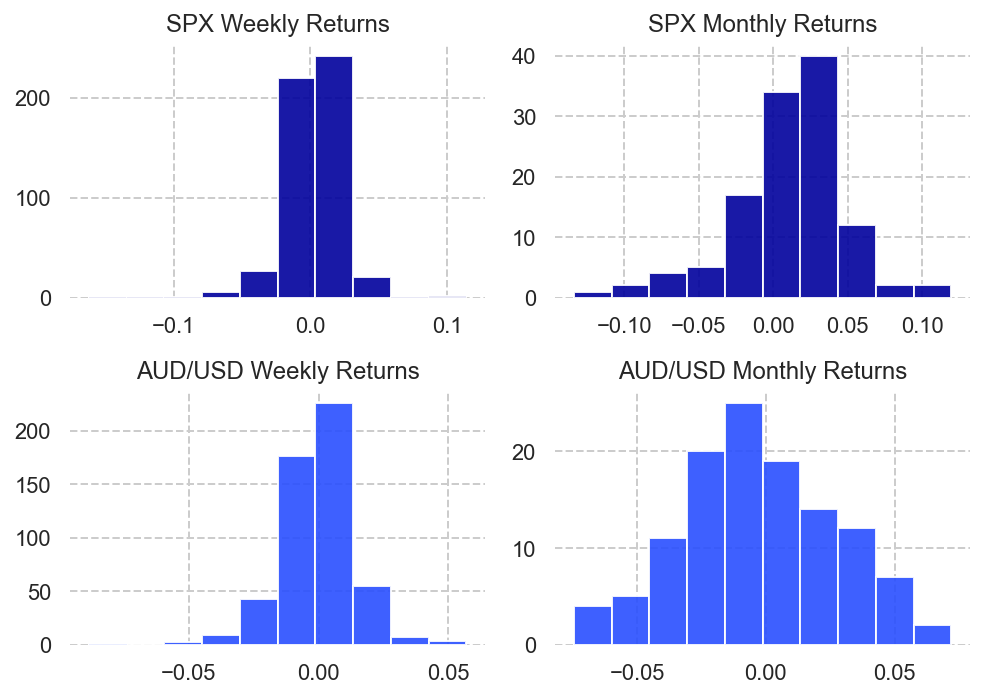

In [5]:
fig, axs = plt.subplots(2, 2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
alpha = 0.9

axs[0, 0].hist(spx_weekly_returns, alpha=alpha)
axs[0, 0].set_title('SPX Weekly Returns')
axs[0, 0].set_frame_on(False)

axs[0, 1].hist(spx_monthly_returns, alpha=alpha)
axs[0, 1].set_title('SPX Monthly Returns')
axs[0, 1].set_frame_on(False)

axs[1, 0].hist(aud_weekly_returns, color=colors[1], alpha=alpha)
axs[1, 0].set_title('AUD/USD Weekly Returns')
axs[1, 0].set_frame_on(False)

axs[1, 1].hist(aud_monthly_returns, color=colors[1], alpha=alpha)
axs[1, 1].set_title('AUD/USD Monthly Returns')
axs[1, 1].set_frame_on(False)

fig.set_size_inches(7, 5)
plt.tight_layout()
plt.show()

The histograms display bell-shaped data, however, it is still difficulty to see clearly how well these empirical distributions actually follow a normal distribution. A better method is to use qq-plots and ECDFs.

### Quantile Quantile (QQ) Plots and Empirical Cumulative Distribution Function (ECDF)

#### QQ plots
With the help of quantile-quantile (qq) plots we can identify whether two distributions are equal by visual inspection. A qq plots is based on the idea that two identical distributions should have the same quantiles (ignoring a constant scaling factor). Therefore, scatter plotting the quantiles of the two distributions should yield a straight line. In our case, we test whether the returns for each time series is normally distributed. 

This is done by noting that the quantiles of the empirical distribution is the same as the observations themselves, if we look at the $i/n\ \forall i \in \{1,...,n \}$ quantiles. Secondly, we find the same number of quantiles in the normal distribution to match against and plot. However, we do not look at $\Phi^{-1}(\frac{i}{n})$ since this approaches infinity when $i=n$. Instead we compute $\Phi^{-1}(\frac{i - 0.5}{n})$.

Also, a so-called qq line is added to more easily if the distribtuions fit. This is done by looking at the 25th and 75th percentile point in each distribution, and plotting the apporpriate $y=mx+b$ line.

#### ECDFs
Another method to look for normality is through the empricial CDF (Cumulative Distribution Function). We can plot both the ECDF and the normal CDF and look whether they look equal or not. The ECDF defined as an unbiased estimator of the CDF is defined as below.

$$ \hat{F}_n(x) =\frac{\textrm{\# of observations} \leq x }{n} = \frac{1}{n} \sum_{i=1}^n \mathbb{1}_{x_i \leq x} $$

In addition to observing differences in the grahps comparing the ECDF to the CDF, we can perform a so-called Kolmogorov-Smirnov (KS) test. The test more rigorously answers whether or not the distributions are the same. The test and the accompanying test statistic follows below.

$$\textrm{$H_0:$ There is no difference in the distributions.}$$
$$\textrm{$H_a:$ There is a difference in the distributions. }$$

$$T = \sup_{x \in N} |F(x) - \hat{F}_n(x)|, \quad N = \{x_i \}_{i=1}^n $$

In the hypothesis we reject $H_0$ in favour of $H_a$ if...



In [6]:
def qq_plot_normal(data, title, ax):
    observations = data
    observations.sort()
    n_observations = len(observations)

    empirical_quantiles = observations
    theoretical_quantiles = [stats.norm.ppf((i - 0.5)/n_observations) for i in range(1, n_observations + 1)]

    ## qq-line (y = mx + b) based on the 25th and 75th quantile of each distribtuion. 
    (x1, x2) = stats.norm.ppf((0.25, 0.75))
    (y1, y2) = np.quantile(observations, (0.25, 0.75))

    slope = (y2 - y1)/(x2 - x1)
    intercept = y2 - (slope * x2)
    qqrange = np.linspace(theoretical_quantiles[0], theoretical_quantiles[-1])
    qqline = [slope * x + intercept for x in qqrange]

    plot = ax.plot(qqrange, qqline, linestyle='dashdot', color='red')
    plot = ax.scatter(theoretical_quantiles, empirical_quantiles, marker='+', linewidths=0.75, zorder=2)
    ax.set_title(title)
    ax.set_frame_on(False)

    return plot

In [7]:
def ecdf_normal(data, title, ax):
    observations = data
    n_observations = len(observations)
    observations = np.asarray(observations)
    observations.sort()
    observations = [(x-sum(observations)/n_observations)/observations.std() for x in observations]
    probabilities = []

    for i in range(n_observations):
        probability = (i + 1) / n_observations
        probabilities.append(probability)
        
    normal_observations = np.linspace(observations[0], observations[-1])
    normal_cdf = stats.norm.cdf(normal_observations)

    plot = ax.step(observations, probabilities, alpha=0.9)
    plot = ax.plot(normal_observations, normal_cdf, linestyle='dashdot', color='red')
    ax.set_title(title)
    ax.set_frame_on(False)

    return plot

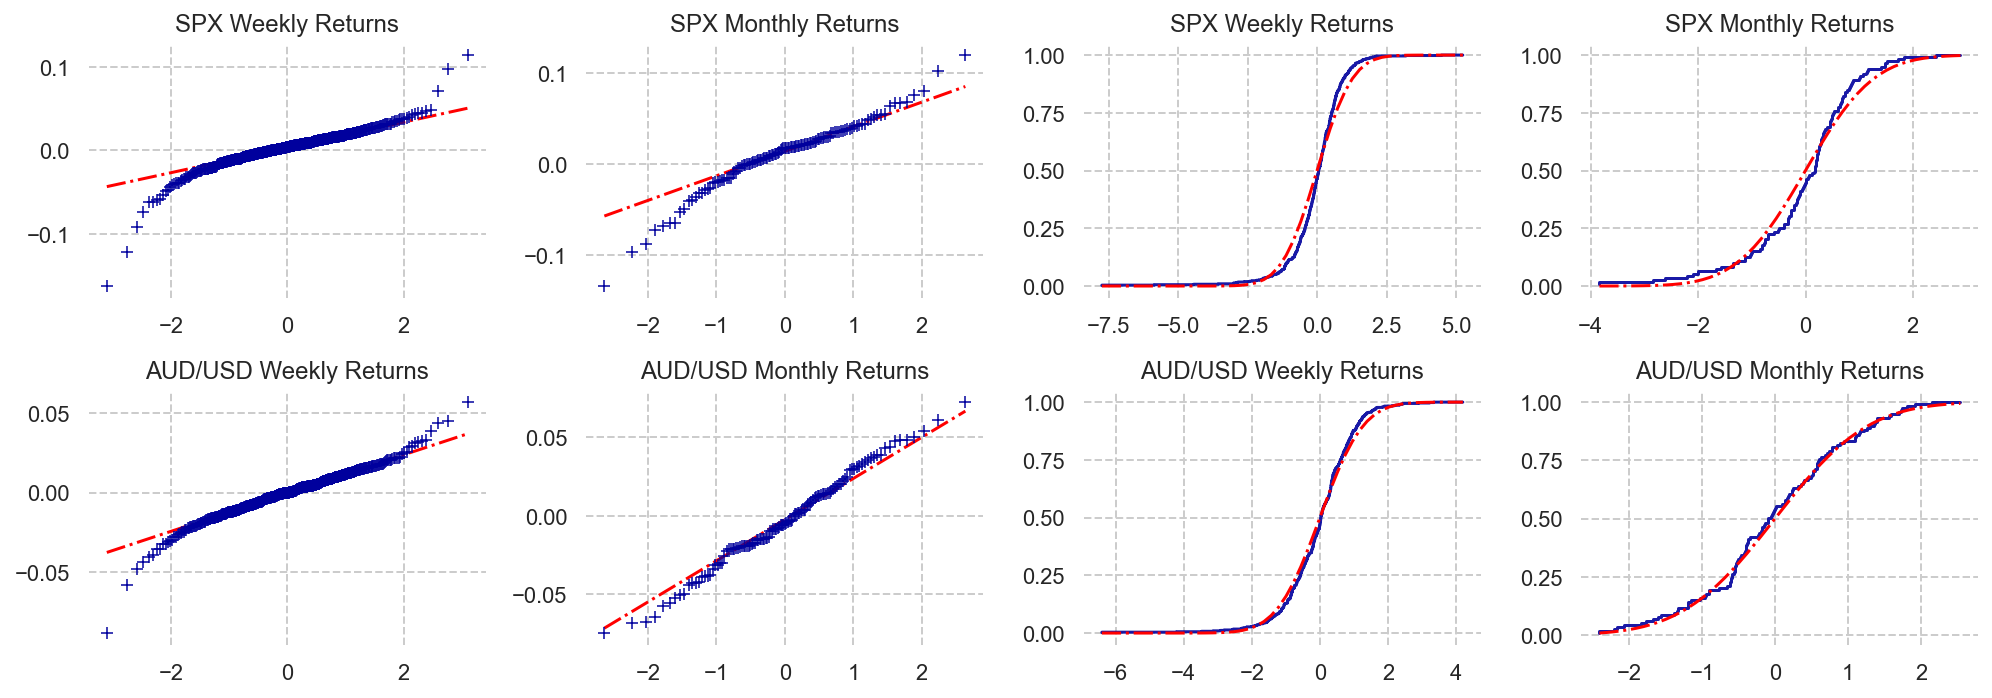

In [8]:
fig, axs = plt.subplots(2, 4)

qq_plot_normal(spx_weekly_returns[1:].to_list(), 'SPX Weekly Returns', axs[0, 0])
qq_plot_normal(spx_monthly_returns[1:].to_list(), 'SPX Monthly Returns', axs[0, 1])
qq_plot_normal(aud_weekly_returns[1:].to_list(), 'AUD/USD Weekly Returns', axs[1, 0])
qq_plot_normal(aud_monthly_returns[1:].to_list(), 'AUD/USD Monthly Returns', axs[1, 1])

ecdf_normal(spx_weekly_returns[1:].to_list(), 'SPX Weekly Returns', axs[0, 2])
ecdf_normal(spx_monthly_returns[1:].to_list(), 'SPX Monthly Returns', axs[0, 3])
ecdf_normal(aud_weekly_returns[1:].to_list(), 'AUD/USD Weekly Returns', axs[1, 2])
ecdf_normal(aud_monthly_returns[1:].to_list(), 'AUD/USD Monthly Returns', axs[1, 3])

fig.set_size_inches(14, 5)
plt.tight_layout()
plt.show()

If the data was purely normally distributed, i.e. $r_t \sim N(0,\sigma)$ the empirical quantiles would form a straight line. However, there are large deviations from the data falling in a straight line. This suggests that modelling returns after $r_t \sim N(0,\sigma)$ is not reasonable. In fact, we can see that this model would pick up most central data, but would not capture the fait tails that financial time series often exhibit. Instead we continue by developing the model for time varying volatility.

Interestingly, we can note that the monthly data seem to be more normally distributed than the weekly data, which is in accordance with the phenomenon of 'aggregated normality'.

### Volatility Estimation and Modelling

The naive approach to volatility modelling of returns is to simply use the sample or population standard deviation. If we do this in a rolling basis, meaning we apply the standard deviation below in time intervals of 30 and 90 weeks respectivley for our weekly returns of the SPX and AUD/USD we quickly find oddities in this methodology.

$$\sigma_t = \sqrt{\frac{1}{m}\sum_{i=1}^m (r_{t-i} - \bar{r})^2} \approx \sqrt{\frac{1}{m}\sum_{i=1}^m r_{t-i}^2}, \quad \bar{r} = \frac{1}{m} \sum_{i=1}^m r_{t-i}$$

Instead we will quickly move on to more advanced models.

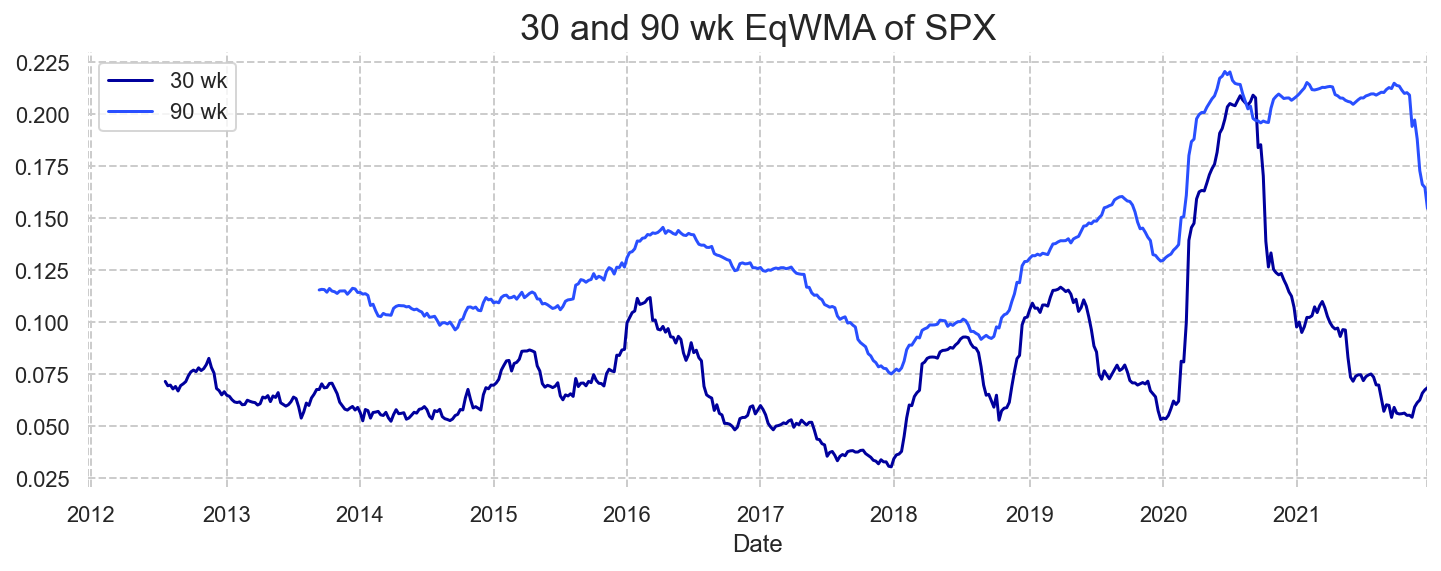

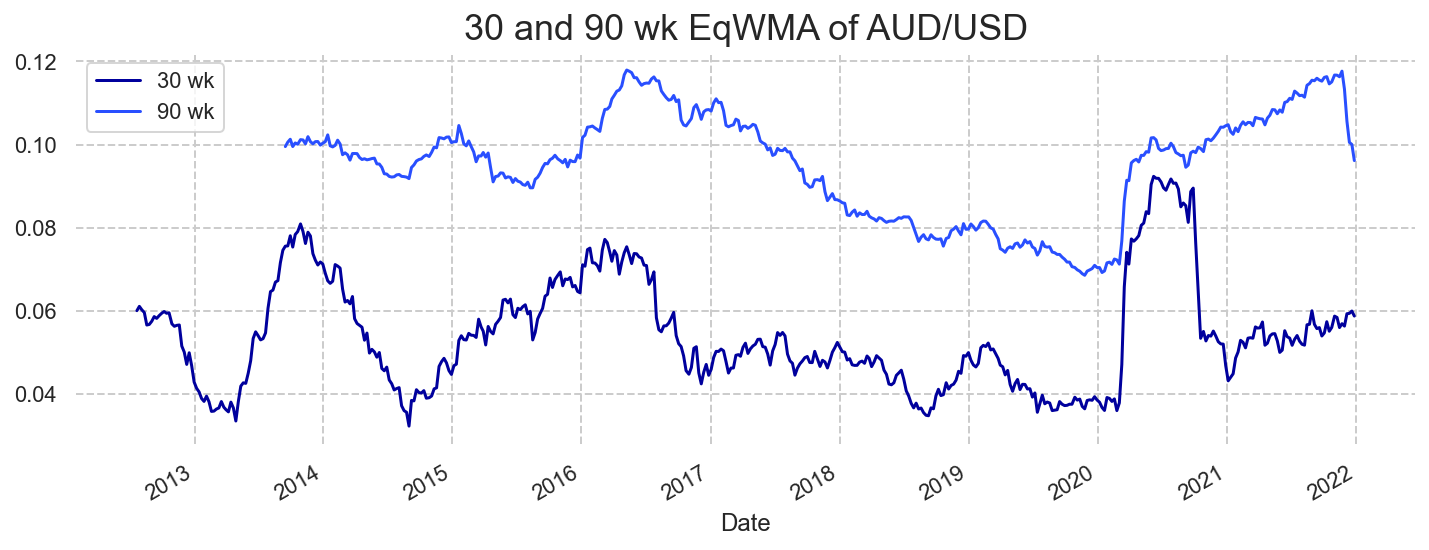

In [9]:
def EqWMA(data):
    window_size = len(data)
    mean = 0
    vol_est = 0

    for i in range(0, len(data)):
        mean = mean + (1 / window_size) * data[i]

    for i in range(0, len(data)):
        vol_est = vol_est + np.sqrt((1 / window_size) * (data[i] - mean) ** 2)

    return vol_est

fig, ax = plt.subplots()
spx_weekly_returns.rolling(30).apply(EqWMA).plot(label='30 wk')
spx_weekly_returns.rolling(90).apply(EqWMA).plot(label='90 wk')
fig.set_size_inches(12, 4)
plt.box(False)
plt.title('30 and 90 wk EqWMA of SPX', fontsize=18)
plt.legend()
plt.show()

fig, ax = plt.subplots()
aud_weekly_returns.rolling(30).apply(EqWMA).plot(label='30 wk')
aud_weekly_returns.rolling(90).apply(EqWMA).plot(label='90 wk')
fig.set_size_inches(12, 4)
plt.box(False)
plt.title('30 and 90 wk EqWMA of AUD/USD', fontsize=18)
plt.legend()
plt.show()

The volatility over time seems to have odd peaks. The volatility rises sharply and stays at a high level for some time periods. This is known as the 'ghost effect', and is simply due to the way we calculate the volatility. Using a moving average, once a data with high volatility has entered the rolloing window, it will stay there for the next $m-1$ time steps. To address this we use the EWMA and GARCH models.

Using a QQ-plot again we can see whether a model $r_t = \sigma_t \xi_t$ which has its $\sigma_t$ determined by a EqWMA fairs better than that of constant volatility. We note that we cannot say follow one single distribution anymore, since the variance changes. Thus we must look at $\frac{r_t}{\sigma_t} \sim N(0,1)$ which has a known constant distribution, in which our samples are $\{\frac{r_i}{\sigma_i}\}_{i=1}^n$.

Note we only do this for the weekly data of both the SPX and AUD/USD.

[]

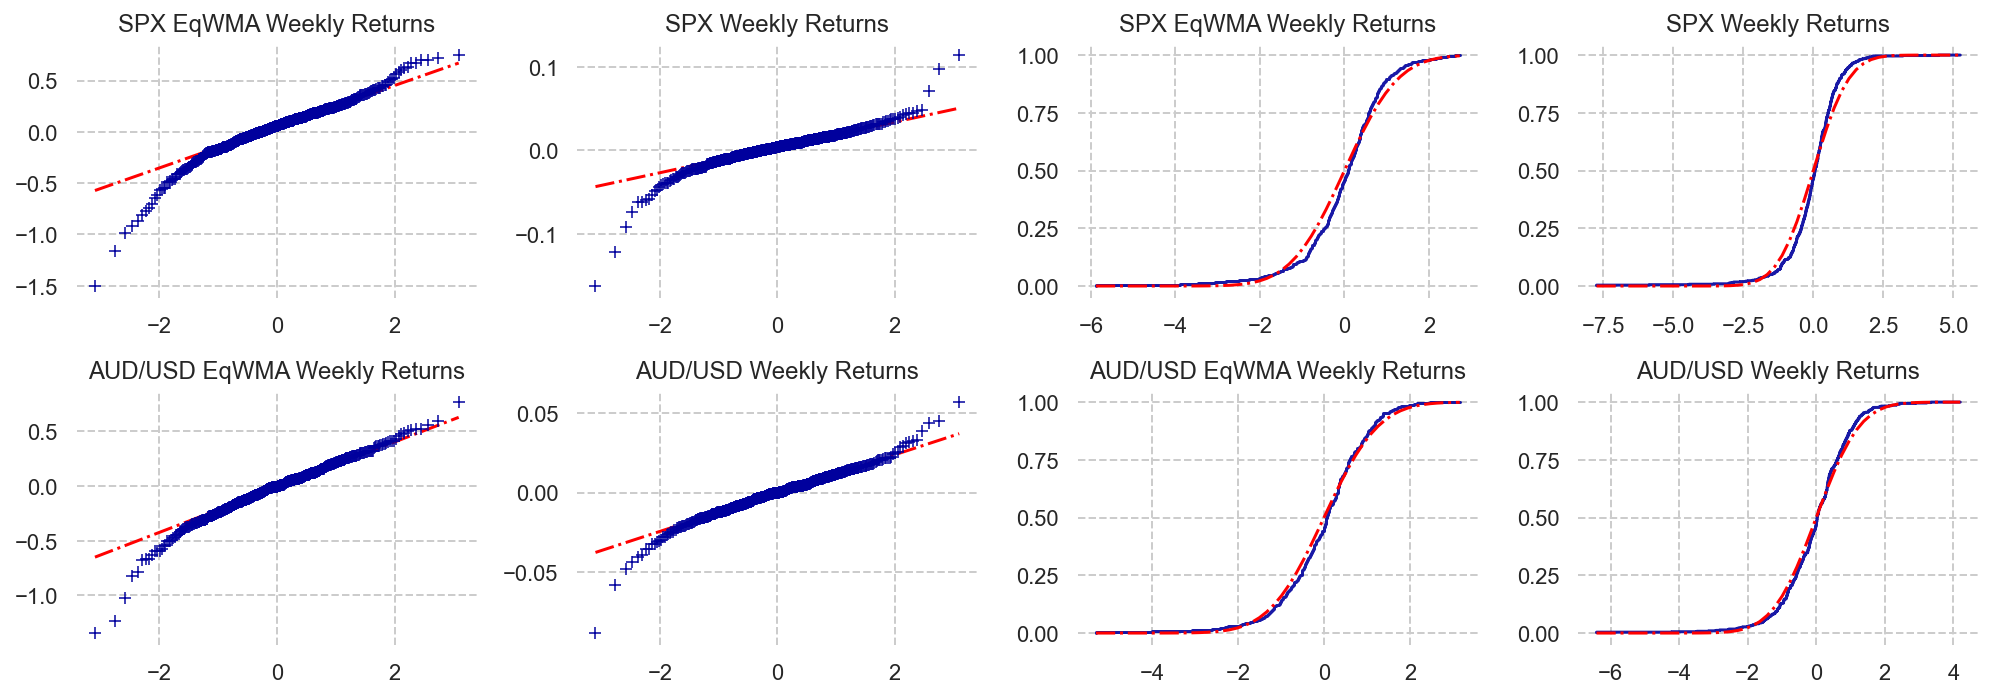

In [10]:
qq_spx_weekly_eqwma = (spx_weekly_returns[30:] / spx_weekly_returns.rolling(30).apply(EqWMA)[30:]).to_list()
qq_aud_weekly_eqwma = (aud_weekly_returns[30:] / aud_weekly_returns.rolling(30).apply(EqWMA)[30:]).to_list()

fig, axs = plt.subplots(2, 4)

qq_plot_normal(qq_spx_weekly_eqwma, 'SPX EqWMA Weekly Returns', axs[0, 0])
qq_plot_normal(spx_weekly_returns[1:].to_list(), 'SPX Weekly Returns', axs[0, 1])
qq_plot_normal(qq_aud_weekly_eqwma, 'AUD/USD EqWMA Weekly Returns', axs[1, 0])
qq_plot_normal(aud_weekly_returns[1:].to_list(), 'AUD/USD Weekly Returns', axs[1, 1])

ecdf_normal(qq_spx_weekly_eqwma, 'SPX EqWMA Weekly Returns', axs[0, 2])
ecdf_normal(spx_weekly_returns[1:].to_list(), 'SPX Weekly Returns', axs[0, 3])
ecdf_normal(qq_aud_weekly_eqwma, 'AUD/USD EqWMA Weekly Returns', axs[1, 2])
ecdf_normal(aud_weekly_returns[1:].to_list(), 'AUD/USD Weekly Returns', axs[1, 3])


fig.set_size_inches(14, 5)
plt.tight_layout()
plt.plot()

### Maximum Likelihood Estimation
In order to work with the GARCH(1, 1) model and a more realistic EWMA model we must Maximum Likelihood Estimate the parameters of these processes. This is done by noting that each return in our model is conditionally normal.


In [11]:
def log_likelihood(param, data):
    # param[0] will be omega
    # param[1] will be alpha
    # param[2] will be beta

    log_likelihood = 0
    vol_est = param[0] + param[1] * (data[1] ** 2) + param[2] * (data[1] ** 2)
    n_observations = len(data)

    for i in range(2, n_observations):
        log_likelihood = log_likelihood + (np.log(vol_est) + (data[i] ** 2) / vol_est)
        vol_est = param[0] + param[1] * (data[i] ** 2) + param[2] * vol_est
        
    return log_likelihood

def GARCH_annualized(data, omega, alpha, beta, measurement_time, title):
    n_observations = len(data)
    vol_est = np.sqrt(omega + alpha * (data[0] ** 2) + beta * (data[0] ** 2))
    vol = []
    for i in range(1, n_observations):
        vol.append(vol_est)
        vol_est = np.sqrt(omega + alpha * (data[i] ** 2) + beta * (vol_est ** 2))
    vol_annual = [x * np.sqrt(1/measurement_time) for x in vol]
    return vol_annual

def EWMA_annualized(data, lamb, measurement_time, title):
    return GARCH_annualized(data, 0, (1-lamb), lamb, measurement_time, title)

In [12]:
from scipy.optimize import minimize

cons_ewma = [{'type': 'eq', 'fun': lambda x: x[0]},
             {'type': 'eq', 'fun': lambda x: x[1] + x[2] - 1},
             {'type': 'ineq', 'fun': lambda x: x[1]},
             {'type': 'ineq', 'fun': lambda x: x[2]}]

x0 = [0, 0.06, 0.94]
result_spx_ewma = minimize(log_likelihood, x0, constraints = cons_ewma, args=spx_weekly_returns)

x0 = [0, 0.12, 0.88]
result_aud_ewma = minimize(log_likelihood, x0, constraints=cons_ewma, args=aud_weekly_returns)

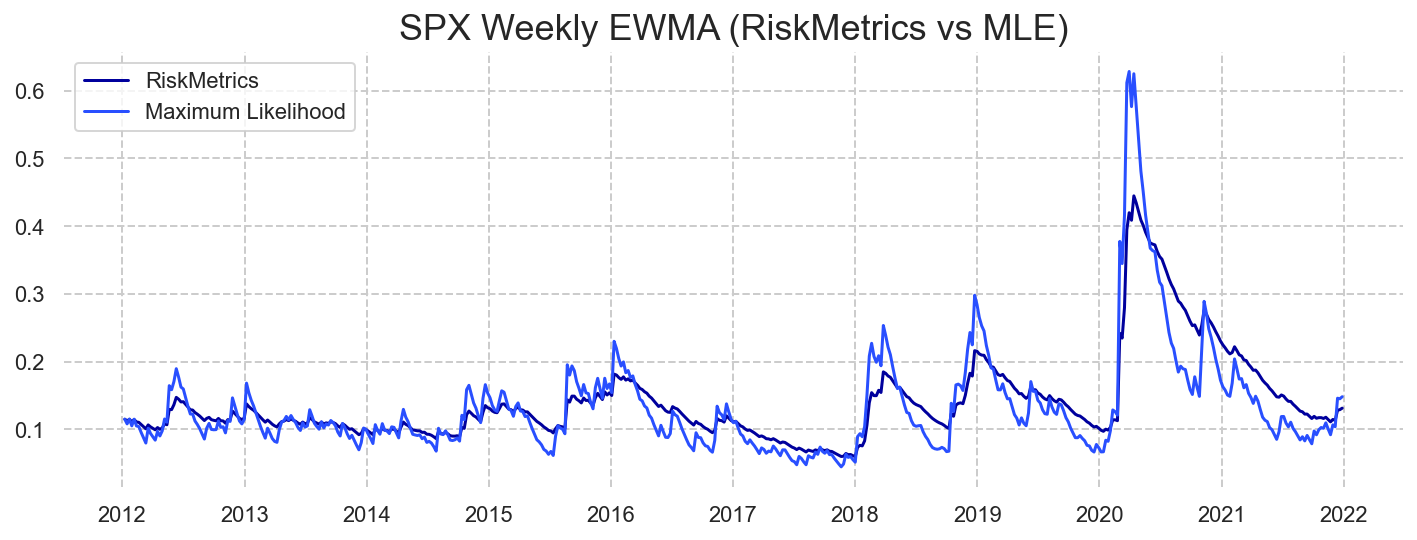

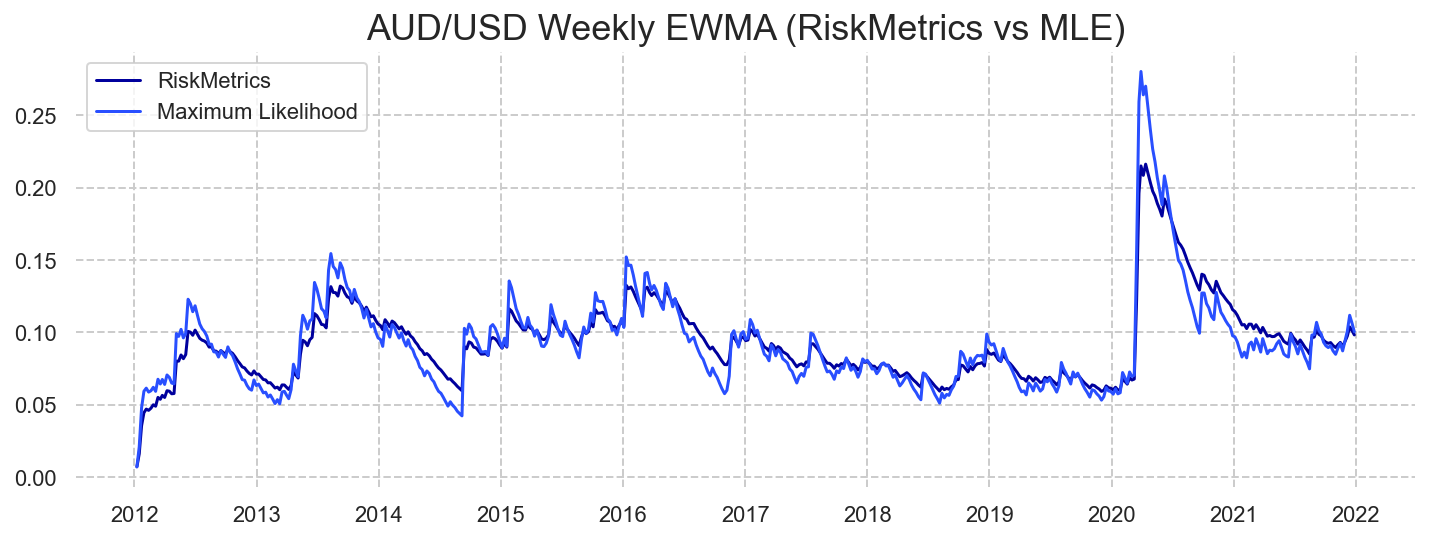

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
spx_ewma_risk_metrics = EWMA_annualized(spx_weekly_returns[1:], 0.94, 1/52, 'SPX Weekly EWMA')
spx_ewma_mle = EWMA_annualized(spx_weekly_returns[1:], result_spx_ewma.x[2], 1/52, 'SPX Weekly EWMA (MLE estimated)')

ax.plot(spx_weekly_returns[2:].index, spx_ewma_risk_metrics, label='RiskMetrics')
ax.plot(spx_weekly_returns[2:].index, spx_ewma_mle, label='Maximum Likelihood')

ax.set_title('SPX Weekly EWMA (RiskMetrics vs MLE)', fontsize=18)
ax.set_frame_on(False)
plt.legend()
plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(12, 4)
aud_ewma_risk_metrics = EWMA_annualized(aud_weekly_returns[1:], 0.94, 1/52, 'SPX Weekly EWMA')
aud_ewma_mle = EWMA_annualized(aud_weekly_returns[1:], result_aud_ewma.x[2], 1/52, 'AUD/USD Weekly EWMA (MLE estimated)')

ax.plot(aud_weekly_returns[2:].index, aud_ewma_risk_metrics, label='RiskMetrics')
ax.plot(aud_weekly_returns[2:].index, aud_ewma_mle, label='Maximum Likelihood')

ax.set_title('AUD/USD Weekly EWMA (RiskMetrics vs MLE)', fontsize=18)
ax.set_frame_on(False)
plt.legend()
plt.show()

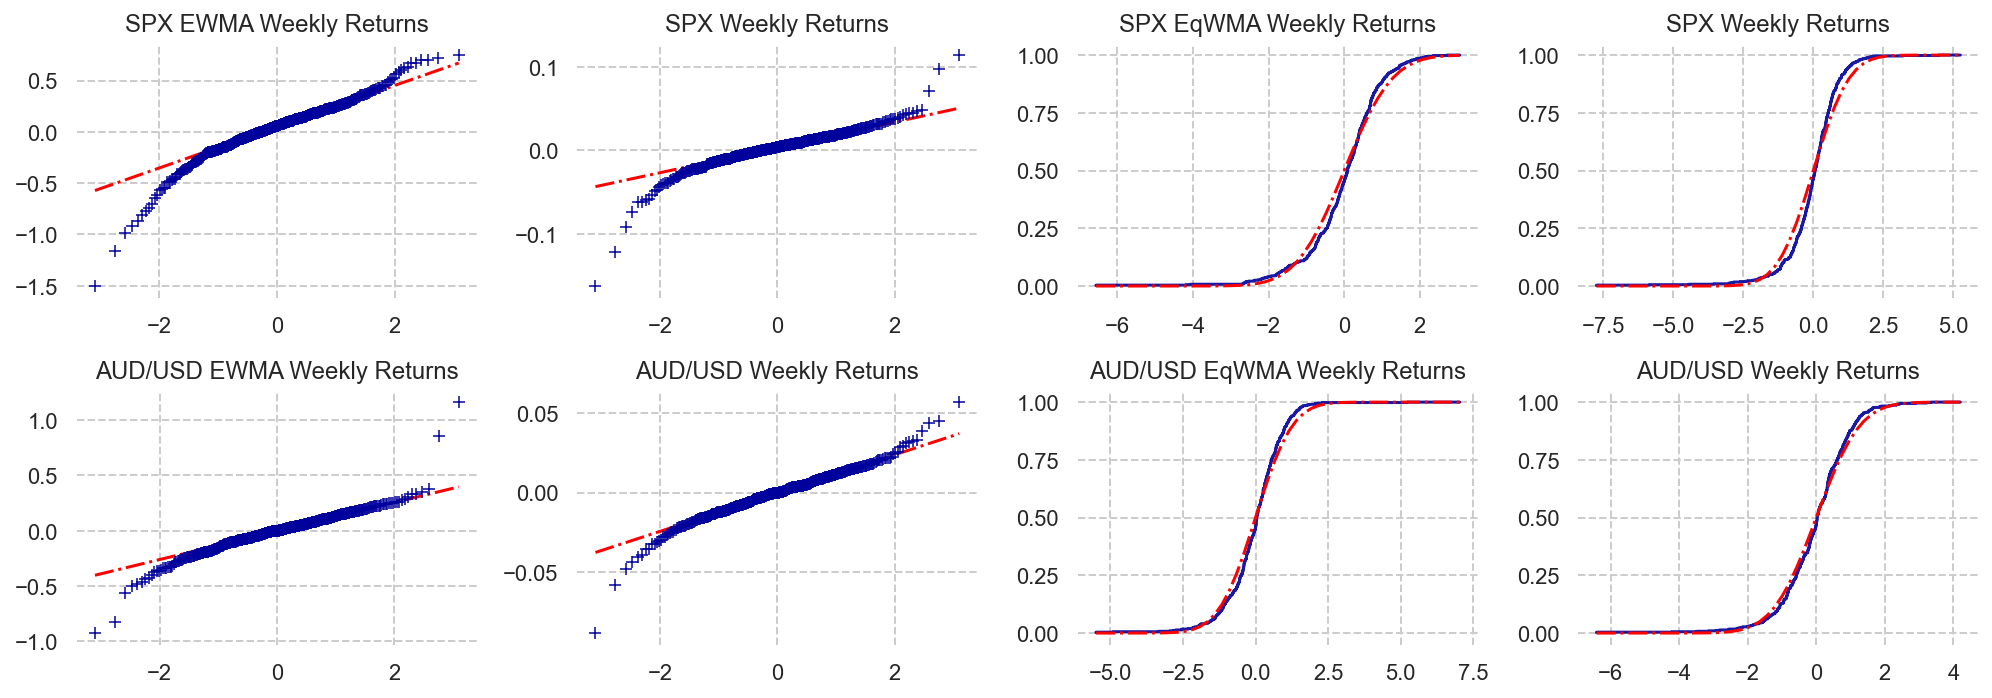

In [14]:
qq_spx_weekly_ewma = (spx_weekly_returns[2:] / spx_ewma_mle).to_list()
qq_aud_weekly_ewma = (aud_weekly_returns[2:] / aud_ewma_mle).to_list()

fig, axs = plt.subplots(2, 4)

qq_plot_normal(qq_spx_weekly_eqwma, 'SPX EWMA Weekly Returns', axs[0, 0])
qq_plot_normal(spx_weekly_returns[1:].to_list(), 'SPX Weekly Returns', axs[0, 1])
qq_plot_normal(qq_aud_weekly_ewma, 'AUD/USD EWMA Weekly Returns', axs[1, 0])
qq_plot_normal(aud_weekly_returns[1:].to_list(), 'AUD/USD Weekly Returns', axs[1, 1])

ecdf_normal(qq_spx_weekly_ewma, 'SPX EqWMA Weekly Returns', axs[0, 2])
ecdf_normal(spx_weekly_returns[1:].to_list(), 'SPX Weekly Returns', axs[0, 3])
ecdf_normal(qq_aud_weekly_ewma, 'AUD/USD EqWMA Weekly Returns', axs[1, 2])
ecdf_normal(aud_weekly_returns[1:].to_list(), 'AUD/USD Weekly Returns', axs[1, 3])

fig.set_size_inches(14, 5)
plt.tight_layout()
plt.show()

Optimizing the GARCH(1,1) parameters $\omega, \alpha, \beta$ can be done with two approaches. With or without variance targeting. Without variance targeting simply means we estimate the parameters $\omega, \alpha, \beta$ directly as one would imagine. Using variance targeting we note that $\omega$ can be rewritten as $\omega = \gamma V_L$, in which $\alpha + \beta + \gamma = 1$ and $V_L$ is the long-run mean reverting variance of the model. Therefore, we can set $V_L$ as a hyperparameter, say the whole data set's standard deviation, and then only be needing to estimate $\alpha$ and $\beta$.

In [15]:
spx_variance_target = spx_weekly_returns.std()
aud_variance_target = aud_weekly_returns.std()

cons_garch = [{'type': 'ineq', 'fun': lambda x:  -x[1] - x[2] + 1},
        {'type': 'ineq', 'fun': lambda x:  x[0]},
        {'type': 'ineq', 'fun': lambda x:  x[1]},
        {'type': 'ineq', 'fun': lambda x:  x[2]}]

def vt_garch_cons(vt):
        return [{'type': 'ineq', 'fun': lambda x:  -x[1] - x[2] + 1},
                {'type': 'eq', 'fun': lambda x:  x[0] - vt + x[1] * vt + x[2] * vt},
                {'type': 'ineq', 'fun': lambda x:  x[1]},
                {'type': 'ineq', 'fun': lambda x:  x[2]}]

x0 = [0.022, 0.3, 0.2]      
result_spx_garch = minimize(log_likelihood, x0, constraints = cons_garch, args=spx_weekly_returns)

x0 = [0.1, 0.3, 0.4]
result_aud_garch = minimize(log_likelihood, x0, constraints = cons_garch, args=aud_weekly_returns)

x0 = [0.01, 0.3, 0.7]       
result_spx_garch_vt = minimize(log_likelihood, x0, constraints = vt_garch_cons(spx_variance_target), args=spx_weekly_returns)

x0 = [0.02, 0.05, 0.88]      
result_aud_garch_vt = minimize(log_likelihood, x0, constraints = vt_garch_cons(aud_variance_target), args=aud_weekly_returns)

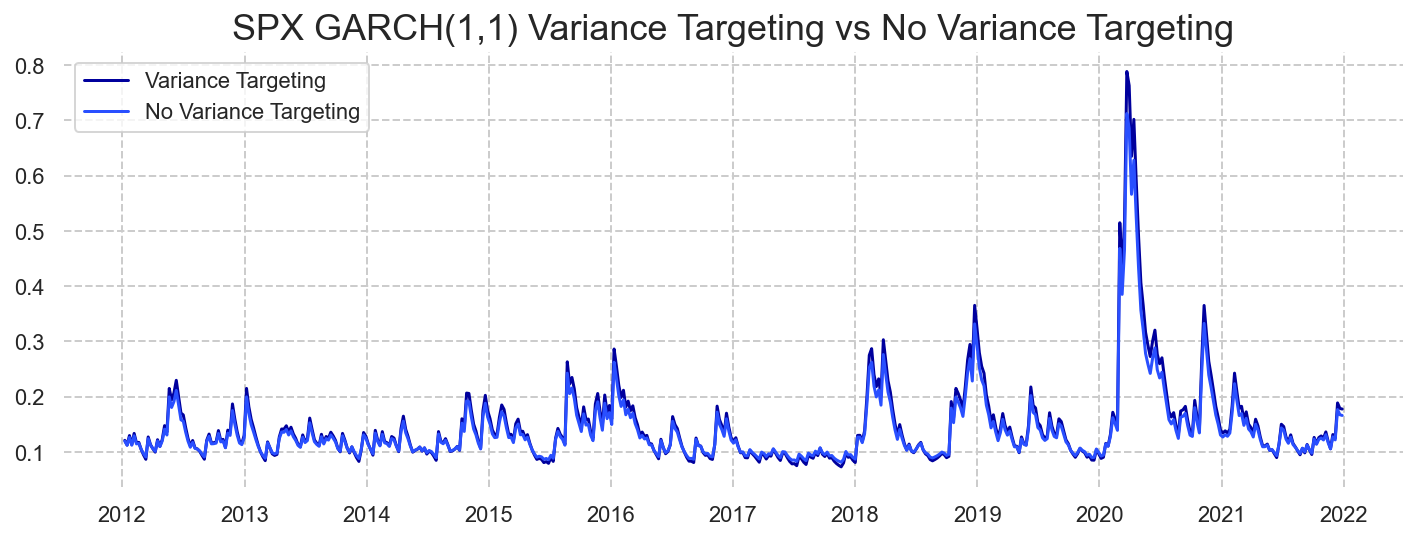

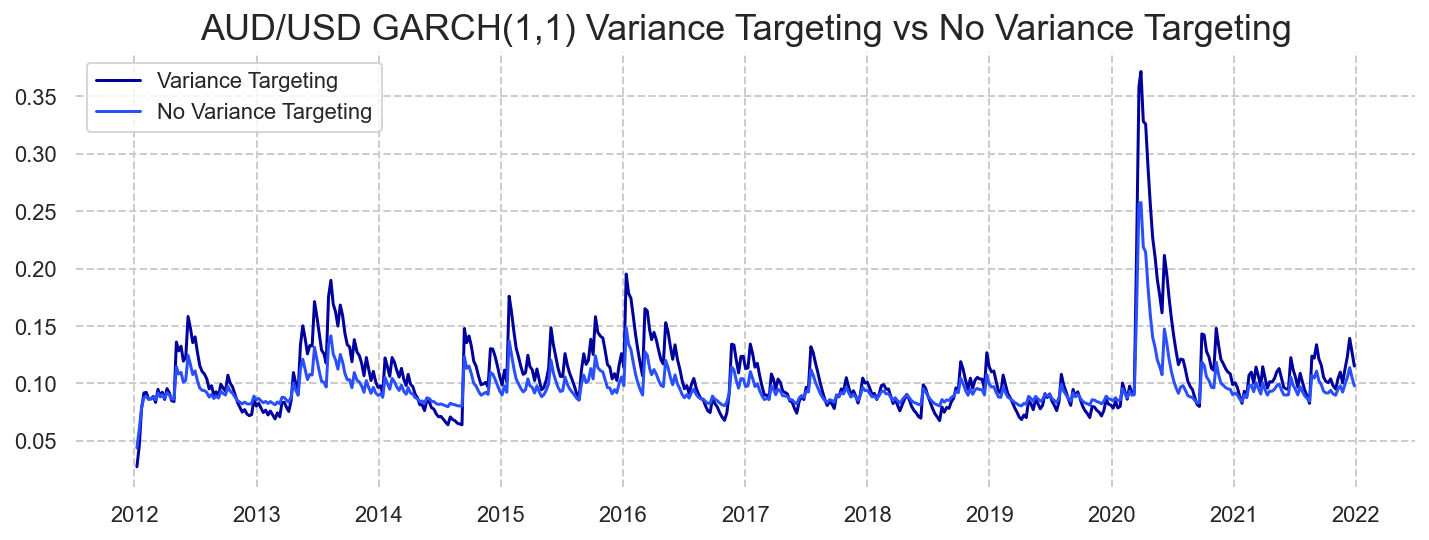

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)

spx_garch = GARCH_annualized(spx_weekly_returns[1:], result_spx_garch.x[0], result_spx_garch.x[1], result_spx_garch.x[2], 1/52, 'SPX Weekly GARCH(1,1) MLE estimated')
spx_garch_vt = GARCH_annualized(spx_weekly_returns[1:], result_spx_garch_vt.x[0], result_spx_garch_vt.x[1], result_spx_garch_vt.x[2], 1/52, 'SPX Weekly GARCH(1,1) MLE estimated')

ax.plot(spx_weekly_returns[2:].index, spx_garch_vt, label='Variance Targeting')
ax.plot(spx_weekly_returns[2:].index, spx_garch, label='No Variance Targeting')

ax.set_frame_on(False)
ax.set_title('SPX GARCH(1,1) Variance Targeting vs No Variance Targeting', fontsize=18)
plt.legend()
plt.show()


fig, ax = plt.subplots()
fig.set_size_inches(12, 4)

aud_garch = GARCH_annualized(aud_weekly_returns[1:], result_aud_garch.x[0], result_aud_garch.x[1], result_aud_garch.x[2], 1/52, 'AUD/USD Weekly GARCH(1,1) (MLE esimated)')
aud_garch_vt = GARCH_annualized(aud_weekly_returns[1:], result_aud_garch_vt.x[0], result_aud_garch_vt.x[1], result_aud_garch_vt.x[2], 1/52, 'AUD/USD Weekly GARCH(1,1) (MLE esimated)')

ax.plot(aud_weekly_returns[2:].index, aud_garch_vt, label='Variance Targeting')
ax.plot(aud_weekly_returns[2:].index, aud_garch, label='No Variance Targeting')

ax.set_frame_on(False)
ax.set_title('AUD/USD GARCH(1,1) Variance Targeting vs No Variance Targeting', fontsize=18)
plt.legend()
plt.show()

In order to look how much better a GARCH(1,1) for the returns are we use a QQ plot again. We know that $r_t \sim N(0, \sigma_t)$ which means that the returns are sampled from different normal distributions. However, normalizing we see that $ \frac{r_t}{\sigma_t} \sim N(0, 1)$. We can therefore sample this quotient instead and examine if it is normally distributed. Using the data we obtained previously we end up with the QQ-plots below for weekly returns. These are compared with the same QQ-plot when $\sigma$ is assumed to be constant. Due to the drastic similarity with and without variance targeting in the GARCH(1,1) volatility estimation, we focus soley on the models with no variance targeting.

It is clearly visible that the naive model of $r_t \sim (0, \sigma)$ is worse than the $r_t \sim N(0, \sigma_t)$ in which $\sigma_t = \omega + \alpha r_{t-1}^2 + \beta \sigma_{t-1}^2$. However, the GARCH(1,1) model of the returns still don't capture the (left) fat tails completely. Therefore, if we were to use this model we it would not fully capture extreme negative returns. 

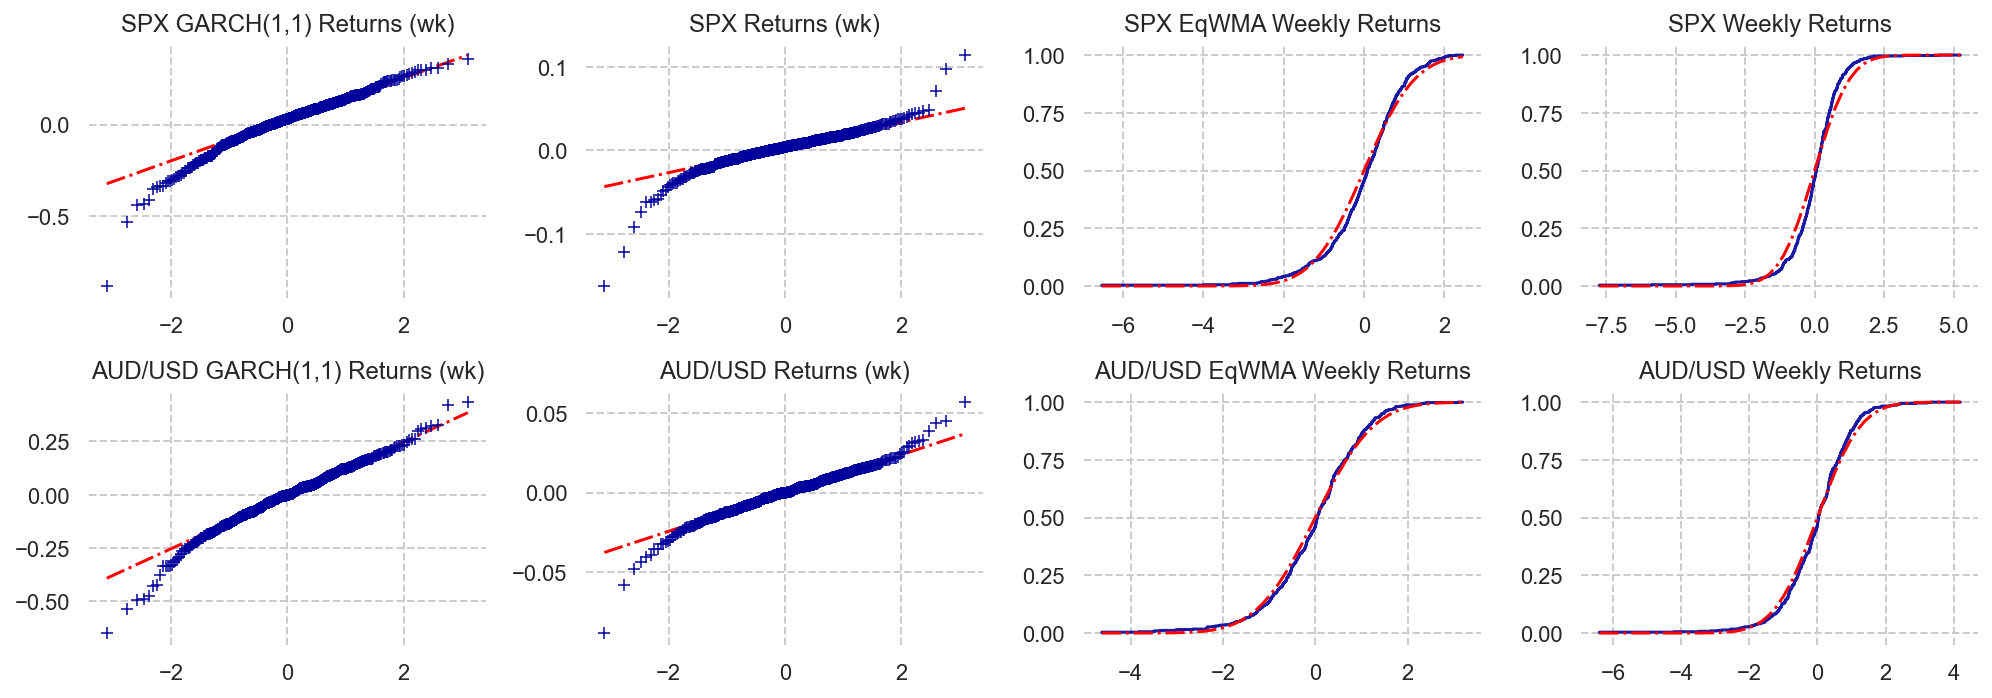

In [17]:
fig, axs = plt.subplots(2, 4)

qq_spx_weekly_garch = (spx_weekly_returns[2:] / spx_garch).to_list()
qq_aud_weekly_garch = (aud_weekly_returns[2:] / aud_garch).to_list()

qq_plot_normal(qq_spx_weekly_garch, 'SPX GARCH(1,1) Returns (wk)', axs[0, 0])
qq_plot_normal(spx_weekly_returns[1:].to_list(), 'SPX Returns (wk)', axs[0, 1])
qq_plot_normal(qq_aud_weekly_garch, 'AUD/USD GARCH(1,1) Returns (wk)', axs[1, 0])
qq_plot_normal(aud_weekly_returns[1:].to_list(), 'AUD/USD Returns (wk)', axs[1, 1])

ecdf_normal(qq_spx_weekly_garch, 'SPX EqWMA Weekly Returns', axs[0, 2])
ecdf_normal(spx_weekly_returns[1:].to_list(), 'SPX Weekly Returns', axs[0, 3])
ecdf_normal(qq_aud_weekly_garch, 'AUD/USD EqWMA Weekly Returns', axs[1, 2])
ecdf_normal(aud_weekly_returns[1:], 'AUD/USD Weekly Returns', axs[1, 3])

fig.set_size_inches(14, 5)
plt.tight_layout()
plt.show()

### Summary of Model Fits for Weekly Data

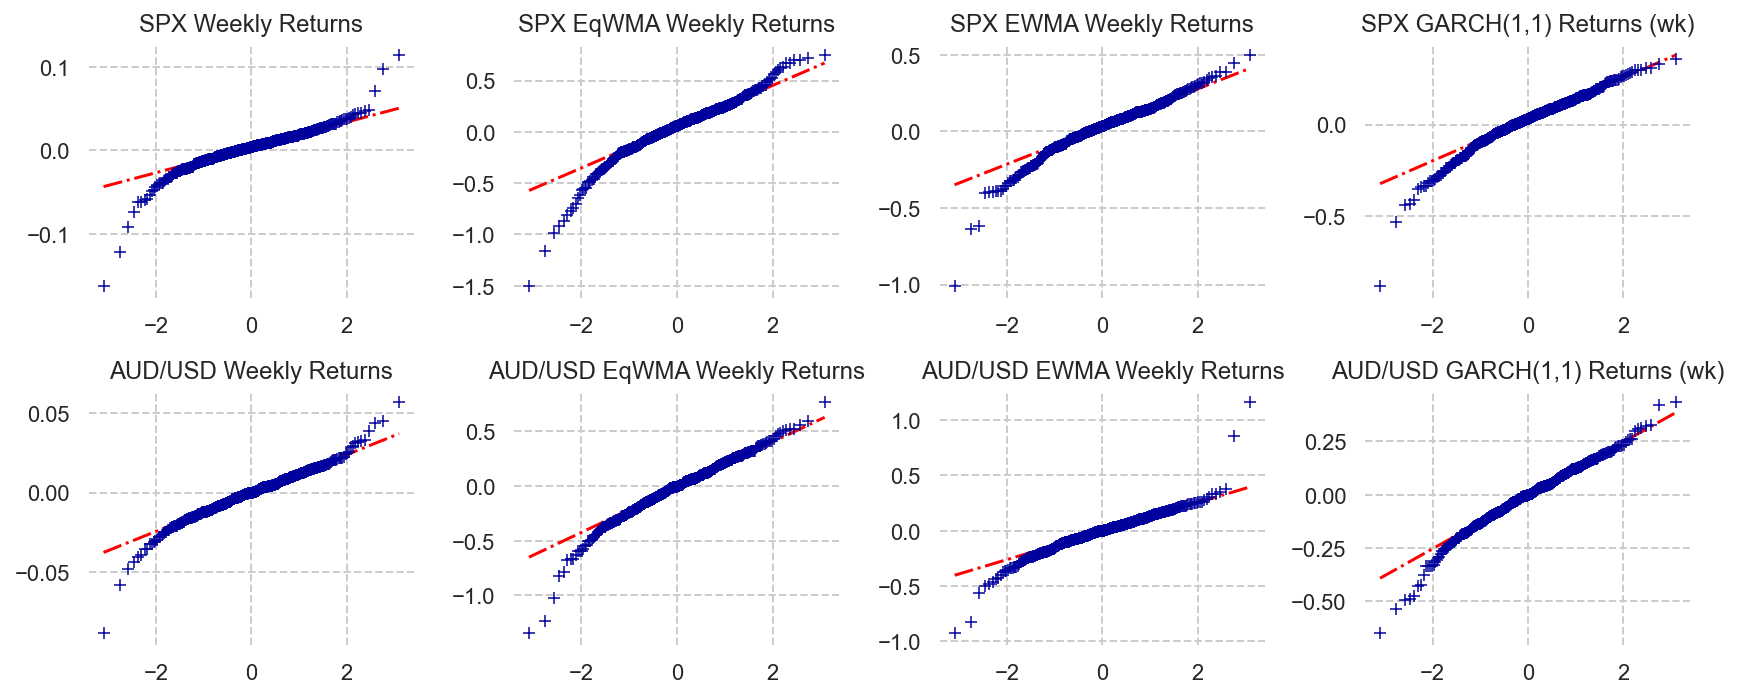

In [18]:
fig, axs = plt.subplots(2, 4)

qq_plot_normal(spx_weekly_returns[1:].to_list(), 'SPX Weekly Returns', axs[0, 0])
qq_plot_normal(aud_weekly_returns[1:].to_list(), 'AUD/USD Weekly Returns', axs[1, 0])

qq_plot_normal(qq_spx_weekly_eqwma, 'SPX EqWMA Weekly Returns', axs[0, 1])
qq_plot_normal(qq_aud_weekly_eqwma, 'AUD/USD EqWMA Weekly Returns', axs[1, 1])

qq_plot_normal(qq_spx_weekly_ewma, 'SPX EWMA Weekly Returns', axs[0, 2])
qq_plot_normal(qq_aud_weekly_ewma, 'AUD/USD EWMA Weekly Returns', axs[1, 2])

qq_plot_normal(qq_spx_weekly_garch, 'SPX GARCH(1,1) Returns (wk)', axs[0, 3])
qq_plot_normal(qq_aud_weekly_garch, 'AUD/USD GARCH(1,1) Returns (wk)', axs[1, 3])

fig.set_size_inches(12, 5)
plt.tight_layout()
plt.show()

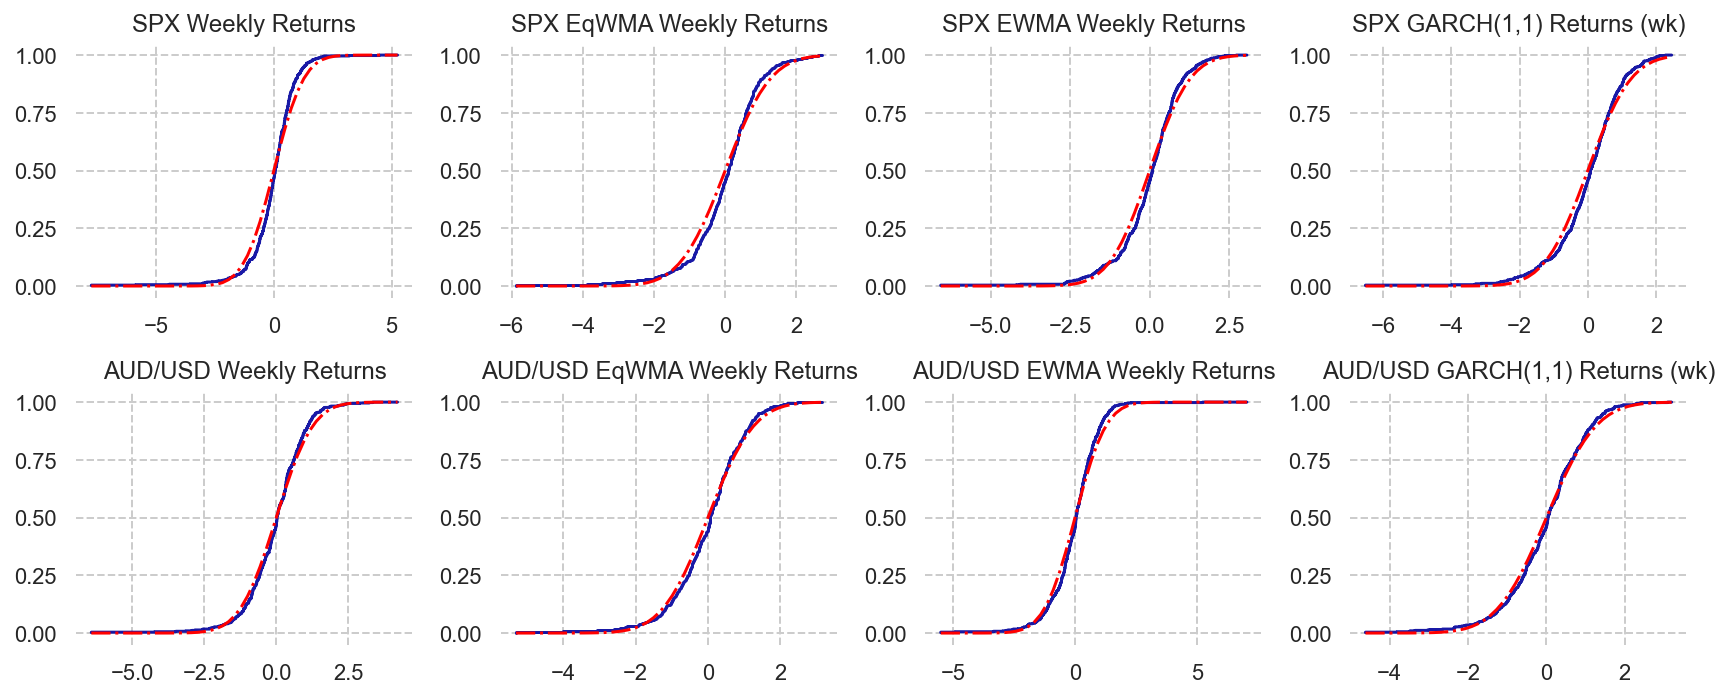

In [19]:
fig, axs = plt.subplots(2, 4)

ecdf_normal(spx_weekly_returns[1:].to_list(), 'SPX Weekly Returns', axs[0, 0])
ecdf_normal(qq_spx_weekly_eqwma, 'SPX EqWMA Weekly Returns', axs[0, 1])
ecdf_normal(qq_spx_weekly_ewma, 'SPX EWMA Weekly Returns', axs[0, 2])
ecdf_normal(qq_spx_weekly_garch, 'SPX GARCH(1,1) Returns (wk)', axs[0, 3])


ecdf_normal(aud_weekly_returns[1:].to_list(), 'AUD/USD Weekly Returns', axs[1, 0])
ecdf_normal(qq_aud_weekly_eqwma, 'AUD/USD EqWMA Weekly Returns', axs[1, 1])
ecdf_normal(qq_aud_weekly_ewma, 'AUD/USD EWMA Weekly Returns', axs[1, 2])
ecdf_normal(qq_aud_weekly_garch, 'AUD/USD GARCH(1,1) Returns (wk)', axs[1, 3])


fig.set_size_inches(12, 5)
plt.tight_layout()
plt.show()

### Volatility Forecast and Monte Carlo Simulation

With our GARCH(1,1) model we have now successfully been able to measure volatility in a precise manner than with previous models (EqWMA, EWMA). This information is useful in and of itself, however, we would also like to be able to forecast future variance. 


#### Monte Carlo Simulation

In [103]:
new_returns = []
new_volatility = []

periods = 30
dates_sim = pd.date_range(start="2021-12-28", periods=periods+1, freq='W')


initial_return = spx_weekly_returns[-1]
initial_volatility = spx_garch[-1]

new_returns.append(initial_return)
new_volatility.append(initial_volatility)

params = result_spx_garch.x

for i in range(periods):
    xi = np.random.normal(0, 1)
    new_vol = np.sqrt(params[0] + params[1] * new_returns[i] ** 2 + params[2] * new_volatility[i] ** 2)
    new_ret = new_vol * xi
    new_volatility.append(new_vol)
    new_returns.append(new_ret)

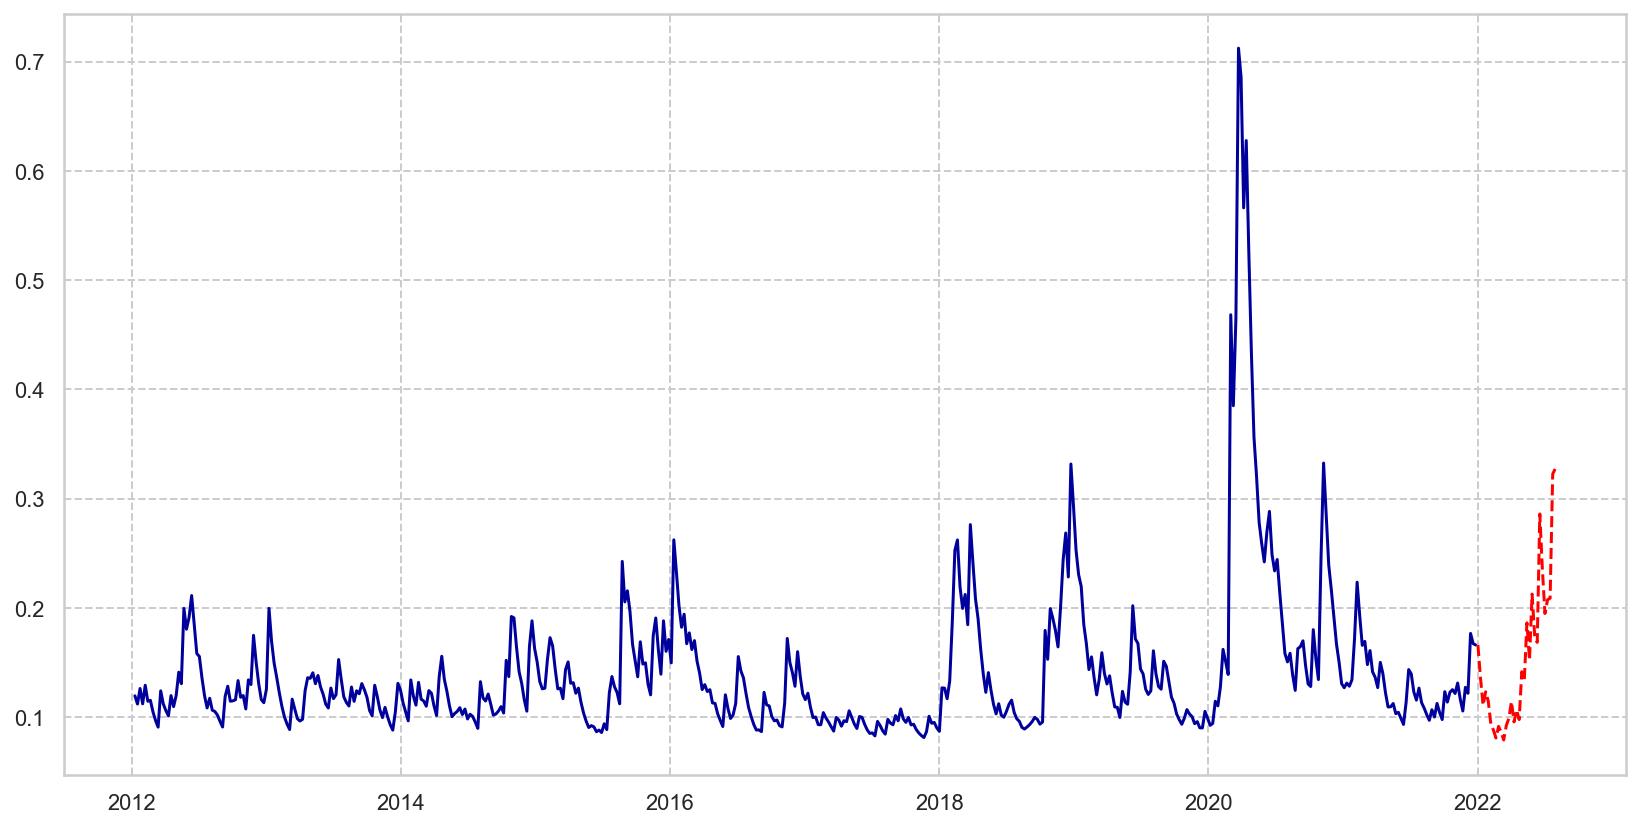

In [114]:
fig, ax = plt.subplots()
plt.plot(spx_weekly_returns[2:].index, spx_garch)
plt.plot(dates_sim, new_volatility, linestyle='dashed', color='red')
fig.set_size_inches(14, 7)
plt.show()